In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf

import sys
sys.path.append('/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/')

from enum import Enum

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense

import tensorflow_probability as tfp
from scipy.stats import beta, truncnorm


# Local imports from model.py, data.py
from model import CovidModel, LogPoissonProb, get_logging_callbacks, Comp, Vax
from data import read_data, create_warmup
#from plots import make_all_plots

import scipy

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20}) # set plot font sizes

2022-02-10 17:50:00.414044: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-10 17:50:00.414084: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [64]:
transition_window =10

warmup_start = '20210421'
warmup_end = '20210430'
train_start = '20210501'
train_end = '20210731'
test_start = '20210801'
test_end = '20210831'

state = 'Massachusetts'
state_abbrev = 'MA'

data_dir = '../data'
covid_estim_date = '20210901'
hhs_date = '20210903'
owid_date = '20210903'

# Learning rate
learning_rate = 0.05

In [3]:
df = read_data(data_dir=data_dir,
               covid_estim_date=covid_estim_date,
               hhs_date=hhs_date,
               owid_date=owid_date,
               state=state, state_abbrev=state_abbrev)

In [4]:
df

,icu_count,general_ward_count,deaths_covid,asymp,extreme,mild,Rt,general_ward_in,vax_pct
date,,,,,,,,,
2019-12-25,NaN,NaN,NaN,0.000006,6.555663e-11,5.714537e-08,0.992215,NaN,NaN
2019-12-26,NaN,NaN,NaN,0.000006,5.584121e-10,3.892314e-07,1.055331,NaN,NaN
2019-12-27,NaN,NaN,NaN,0.000006,2.045071e-09,1.009780e-06,1.110538,NaN,NaN
2019-12-28,NaN,NaN,NaN,0.000007,4.996819e-09,1.784756e-06,1.158677,NaN,NaN
2019-12-29,NaN,NaN,NaN,0.000007,9.617803e-09,2.581918e-06,1.201151,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-08-31,171.0,500.0,4.0,5744.449475,4.605118e+01,3.266123e+03,1.190514,67.0,0.6597
2021-09-01,161.0,490.0,12.0,5959.757047,4.741058e+01,3.375344e+03,1.197465,85.0,0.6604
2021-09-02,168.0,517.0,10.0,NaN,NaN,NaN,NaN,72.0,0.6613


In [5]:
# get warmup arrays, splitting on vaccination status
warmup_asymp, warmup_mild, count_gen, count_icu = create_warmup(df, 
                                                          warmup_start, 
                                                          warmup_end,
                                                          0,0,0,0)

# re-combine
#warmup_asymp = warmup_asymp[Vax.no.value] + warmup_asymp[Vax.yes.value]
#warmup_mild = warmup_mild[Vax.no.value] + warmup_asymp[Vax.yes.value]

In [6]:
vax_statuses = [Vax.yes, Vax.no]


In [7]:
# Set warmup priors/initializations

warmup_A_params = {}
warmup_M_params = {}
warmup_G_params = {}
warmup_GR_params = {}
init_count_G = {}
warmup_I_params = {}
warmup_IR_params = {}
init_count_I = {}

for vax_status in [status.value for status in vax_statuses]:
                
    
    warmup_A_params[vax_status] = {}
    warmup_A_params[vax_status]['prior'] = []
    warmup_A_params[vax_status]['posterior_init'] = []

    warmup_M_params[vax_status] = {}
    warmup_M_params[vax_status]['prior'] = []
    warmup_M_params[vax_status]['posterior_init'] = []

    warmup_G_params[vax_status] = {}
    warmup_G_params[vax_status]['prior'] = []
    warmup_G_params[vax_status]['posterior_init'] = []
    warmup_GR_params[vax_status] = {}
    warmup_GR_params[vax_status]['prior'] = []
    warmup_GR_params[vax_status]['posterior_init'] = []
    
    warmup_I_params[vax_status] = {}
    warmup_I_params[vax_status]['prior'] = []
    warmup_I_params[vax_status]['posterior_init'] = []
    warmup_IR_params[vax_status] = {}
    warmup_IR_params[vax_status]['prior'] = []
    warmup_IR_params[vax_status]['posterior_init'] = []
    
    init_count_G[vax_status] = {}
    init_count_G[vax_status]['prior'] ={}
    init_count_G[vax_status]['posterior_init'] ={}
    
    init_count_I[vax_status] = {}
    init_count_I[vax_status]['prior'] ={}
    init_count_I[vax_status]['posterior_init'] ={}
    
    # Set priors
    
    init_count_G[vax_status]['prior'] = {'loc':count_gen[vax_status], 'scale':count_gen[vax_status]/10}
    init_count_I[vax_status]['prior'] = {'loc':count_icu[vax_status], 'scale':count_icu[vax_status]/10}

    
    
   
    warmup_A_params[vax_status]['prior'] = {'intercept': warmup_asymp[vax_status][0]/2,
                                            'slope': 0,
                                                'scale': warmup_asymp[vax_status][0]/2/10}

    warmup_M_params[vax_status]['prior'] = {'intercept': warmup_mild[vax_status][0]/2,
                                            'slope': 0,
                                                'scale': warmup_mild[vax_status][0]/2/10}

    warmup_G_params[vax_status]['prior'] = {'intercept': count_gen[vax_status]/10,
                                            'slope': 0,
                                                'scale': count_gen[vax_status]/10}

    warmup_GR_params[vax_status]['prior'] = {'intercept': count_gen[vax_status]/2/10,
                                            'slope': 0,
                                                'scale': count_gen[vax_status]/2/10}

    warmup_I_params[vax_status]['prior'] = {'intercept': count_icu[vax_status]/10,
                                            'slope': 0,
                                                'scale': count_icu[vax_status]/10}

    warmup_IR_params[vax_status]['prior'] = {'intercept': count_icu[vax_status]/2/10,
                                            'slope': 0,
                                                'scale': count_icu[vax_status]/2/10}
    

In [8]:
x_train = tf.cast(df.loc[train_start:train_end,'Rt'].values, dtype=tf.float32)
x_test = tf.cast(df.loc[train_start:test_end,'Rt'].values, dtype=tf.float32)


y_train = {}
y_train['G_in'] = tf.cast(df.loc[train_start:train_end,'general_ward_in'], dtype=tf.float32)
y_train['G_count'] = tf.cast(df.loc[train_start:train_end,'general_ward_count'], dtype=tf.float32)
y_train['I_count'] = tf.cast(df.loc[train_start:train_end,'icu_count'], dtype=tf.float32)
y_train['D_in'] = tf.cast(df.loc[train_start:train_end,'deaths_covid'], dtype=tf.float32) + 1

y_test = {}
y_test['G_in'] = tf.cast(df.loc[train_start:test_end,'general_ward_in'], dtype=tf.float32)
y_test['G_count'] = tf.cast(df.loc[train_start:test_end,'general_ward_count'], dtype=tf.float32)
y_test['I_count'] = tf.cast(df.loc[train_start:test_end,'icu_count'], dtype=tf.float32)
y_test['D_in'] = tf.cast(df.loc[train_start:test_end,'deaths_covid'], dtype=tf.float32)

2022-02-10 17:50:03.099445: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-02-10 17:50:03.100011: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-10 17:50:03.100129: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-02-10 17:50:03.100182: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-02-10 17:50:03.100216: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [9]:

T_serial = {}
T_serial['prior'] ={'loc':5.8, 'scale':1}


epsilon = {}
epsilon['prior'] ={'a':1, 'b':1}

delta = {}
delta['prior'] ={'a':1, 'b':1}

rho_M = {}
lambda_M = {}
nu_M = {}
rho_G = {}
lambda_G = {}
nu_G = {}

rho_I = {}
lambda_I = {}
nu_I = {}
lambda_I_bar = {}
nu_I_bar = {}

rho_D = {}
lambda_D = {}
nu_D = {}
lambda_D_bar = {}
nu_D_bar = {}

for vax_status in [status.value for status in vax_statuses]:
    
    rho_M[vax_status] = {}
    rho_M[vax_status]['prior'] = {'a': 1, 'b': 1}
    #rho_M[vax_status]['prior'] = {'a': 31.8, 'b': 10.3}


    lambda_M[vax_status] = {}
    lambda_M[vax_status]['prior'] = {'loc': 4.7, 'scale': 1}


    nu_M[vax_status] = {}
    nu_M[vax_status]['prior'] = {'loc': 3.1, 'scale': 1.2}


    rho_G[vax_status] = {}
    rho_G[vax_status]['prior'] = {'a': 1, 'b': 1}
    #rho_G[vax_status]['prior'] = {'a': 31.8, 'b': 10.3}
    lambda_G[vax_status] = {}
    lambda_G[vax_status]['prior'] = {'loc': 3.3, 'scale': 1.0}
    nu_G[vax_status] = {}
    nu_G[vax_status]['prior'] = {'loc': 9.0, 'scale': 3}
    
    rho_I[vax_status] = {}
    rho_I[vax_status]['prior'] = {'a': 1, 'b': 1}
    #rho_I[vax_status]['prior'] = {'a': 31.8, 'b': 10.3}
    lambda_I[vax_status] = {}
    lambda_I[vax_status]['prior'] = {'loc': 3.3, 'scale': 1.0}
    nu_I[vax_status] = {}
    nu_I[vax_status]['prior'] = {'loc': 9.0, 'scale': 3}
    lambda_I_bar[vax_status] = {}
    lambda_I_bar[vax_status]['prior'] = {'loc': 3.3, 'scale': 1.0}
    nu_I_bar[vax_status] = {}
    nu_I_bar[vax_status]['prior'] = {'loc': 9.0, 'scale': 3}

    rho_D[vax_status] = {}
    rho_D[vax_status]['prior'] = {'a': 1, 'b': 1}
    #rho_D[vax_status]['prior'] = {'a': 31.8, 'b': 10.3}
    lambda_D[vax_status] = {}
    lambda_D[vax_status]['prior'] = {'loc': 3.3, 'scale': 1.0}
    nu_D[vax_status] = {}
    nu_D[vax_status]['prior'] = {'loc': 9.0, 'scale': 3}
    lambda_D_bar[vax_status] = {}
    lambda_D_bar[vax_status]['prior'] = {'loc': 3.3, 'scale': 1.0}
    nu_D_bar[vax_status] = {}
    nu_D_bar[vax_status]['prior'] = {'loc': 9.0, 'scale':3}




In [10]:
T_serial_scale = 1.0
delta_scale = 0.2
epsilon_scale = 0.3


rho_M_scale = 0.1
lambda_M_scale = 1.0
nu_M_scale = 1.2

rho_G_scale = 0.1
lambda_G_scale = 1.0
nu_G_scale = 0.2

rho_I_scale = 0.1
lambda_I_scale = 1.0
nu_I_scale = 0.2
lambda_I_bar_scale = 1.0
nu_I_bar_scale = 0.2

rho_D_scale = 0.1
lambda_D_scale = 1.0
nu_D_scale = 0.2
lambda_D_bar_scale = 1.0
nu_D_bar_scale = 0.2

In [11]:
T_serial['posterior_init'] = {'loc': tfp.math.softplus_inverse(4.0),
                                     'scale':tf.cast(tfp.math.softplus_inverse(T_serial_scale),dtype=tf.float32)}
delta['posterior_init'] = {'loc':  tf.cast(np.log(0.1/(1-0.1)),dtype=tf.float32),
                                     'scale':tf.cast(tfp.math.softplus_inverse(delta_scale),dtype=tf.float32)}
epsilon['posterior_init'] = {'loc':  tf.cast(np.log(0.5/(1-0.5)),dtype=tf.float32),
                                     'scale':tf.cast(tfp.math.softplus_inverse(epsilon_scale),dtype=tf.float32)}


for vax_status in [status.value for status in vax_statuses]:
    
    rho_M[vax_status]['posterior_init'] = {'loc': tf.cast(np.log(0.5/(1-0.5)),dtype=tf.float32),
                                          'scale':tf.cast(tfp.math.softplus_inverse(rho_M_scale),dtype=tf.float32)}

    lambda_M[vax_status]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(3.0),dtype=tf.float32),
                                             'scale':tf.cast(tfp.math.softplus_inverse(lambda_M_scale),dtype=tf.float32)}

    nu_M[vax_status]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(5.0),dtype=tf.float32),
                                         'scale':tf.cast(tfp.math.softplus_inverse(nu_M_scale),dtype=tf.float32)}

    rho_G[vax_status]['posterior_init'] = {'loc': tf.cast(np.log(0.1/(1-0.1)),dtype=tf.float32),
                                          'scale':tf.cast(tfp.math.softplus_inverse(rho_G_scale),dtype=tf.float32)}

    lambda_G[vax_status]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(3.3),dtype=tf.float32),
                                             'scale':tf.cast(tfp.math.softplus_inverse(lambda_G_scale),dtype=tf.float32)}

    nu_G[vax_status]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(9.0),dtype=tf.float32),
                                         'scale':tf.cast(tfp.math.softplus_inverse(nu_G_scale),dtype=tf.float32)}
    
    rho_I[vax_status]['posterior_init'] = {'loc': tf.cast(np.log(0.1/(1-0.1)),dtype=tf.float32),
                                          'scale':tf.cast(tfp.math.softplus_inverse(rho_I_scale),dtype=tf.float32)}
    lambda_I[vax_status]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(3.3),dtype=tf.float32),
                                             'scale':tf.cast(tfp.math.softplus_inverse(lambda_I_scale),dtype=tf.float32)}
    nu_I[vax_status]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(9.0),dtype=tf.float32),
                                         'scale':tf.cast(tfp.math.softplus_inverse(nu_I_scale),dtype=tf.float32)}
    lambda_I_bar[vax_status]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(3.3),dtype=tf.float32),
                                             'scale':tf.cast(tfp.math.softplus_inverse(lambda_I_bar_scale),dtype=tf.float32)}
    nu_I_bar[vax_status]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(9.0),dtype=tf.float32),
                                         'scale':tf.cast(tfp.math.softplus_inverse(nu_I_bar_scale),dtype=tf.float32)}
    
    rho_D[vax_status]['posterior_init'] = {'loc': tf.cast(np.log(0.1/(1-0.1)),dtype=tf.float32),
                                          'scale':tf.cast(tfp.math.softplus_inverse(rho_D_scale),dtype=tf.float32)}
    lambda_D[vax_status]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(3.3),dtype=tf.float32),
                                             'scale':tf.cast(tfp.math.softplus_inverse(lambda_D_scale),dtype=tf.float32)}
    nu_D[vax_status]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(9.0),dtype=tf.float32),
                                         'scale':tf.cast(tfp.math.softplus_inverse(nu_D_scale),dtype=tf.float32)}
    lambda_D_bar[vax_status]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(3.3),dtype=tf.float32),
                                             'scale':tf.cast(tfp.math.softplus_inverse(lambda_D_bar_scale),dtype=tf.float32)}
    nu_D_bar[vax_status]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(9.0),dtype=tf.float32),
                                         'scale':tf.cast(tfp.math.softplus_inverse(nu_D_bar_scale),dtype=tf.float32)}
    
    init_count_G[vax_status]['posterior_init'] = {'loc':tf.cast(tfp.math.softplus_inverse(count_gen[vax_status]/100),dtype=tf.float32),
                                                  'scale': tf.cast(tfp.math.softplus_inverse(count_gen[vax_status]/100/10),dtype=tf.float32)}
    init_count_I[vax_status]['posterior_init'] = {'loc':tf.cast(tfp.math.softplus_inverse(count_icu[vax_status]/100),dtype=tf.float32),
                                                  'scale': tf.cast(tfp.math.softplus_inverse(count_icu[vax_status]/100/10),dtype=tf.float32)}
    
    

    # must be positive so reverse softplus the mean
    warmup_A_params[vax_status]['posterior_init'] = {'intercept': tf.cast(tfp.math.softplus_inverse(2000.0/100/2),dtype=tf.float32),
                                                          'slope': tf.cast(0.0, dtype=tf.float32),
                                                         'scale': tf.cast(tfp.math.softplus_inverse(500.0/100/2),dtype=tf.float32)}
    warmup_M_params[vax_status]['posterior_init'] = {'intercept': tf.cast(tfp.math.softplus_inverse(1000.0/100/2),dtype=tf.float32),
                                                          'slope': tf.cast(0.0, dtype=tf.float32),
                                                         'scale': tf.cast(tfp.math.softplus_inverse(100.0/100/2),dtype=tf.float32)}

    warmup_G_params[vax_status]['posterior_init'] = {'intercept': tf.cast(tfp.math.softplus_inverse(500.0/100/2),dtype=tf.float32),
                                                          'slope': tf.cast(0.0, dtype=tf.float32),
                                                         'scale': tf.cast(tfp.math.softplus_inverse(50.0/100/2),dtype=tf.float32)}
    warmup_GR_params[vax_status]['posterior_init']= {'intercept': tf.cast(tfp.math.softplus_inverse(400.0/100/2),dtype=tf.float32),
                                                          'slope': tf.cast(0.0, dtype=tf.float32),
                                                         'scale': tf.cast(tfp.math.softplus_inverse(50.0/100/2),dtype=tf.float32)}
    warmup_I_params[vax_status]['posterior_init'] = {'intercept': tf.cast(tfp.math.softplus_inverse(100.0/100/2),dtype=tf.float32),
                                                          'slope': tf.cast(0.0, dtype=tf.float32),
                                                         'scale': tf.cast(tfp.math.softplus_inverse(30.0/100/2),dtype=tf.float32)}
    warmup_IR_params[vax_status]['posterior_init']= {'intercept': tf.cast(tfp.math.softplus_inverse(90.0/100/2),dtype=tf.float32),
                                                          'slope': tf.cast(0.0, dtype=tf.float32),
                                                         'scale': tf.cast(tfp.math.softplus_inverse(30.0/100/2),dtype=tf.float32)}

model = CovidModel([Vax.no, Vax.yes], [Comp.A, Comp.M, Comp.G, Comp.GR, Comp.I, Comp.IR, Comp.D],
                 transition_window,
                T_serial, epsilon, delta,
                 rho_M, lambda_M, nu_M,
                 rho_G, lambda_G, nu_G,
                 rho_I, lambda_I, nu_I,
                 lambda_I_bar, nu_I_bar,
                 rho_D, lambda_D, nu_D,
                 lambda_D_bar, nu_D_bar,
                 warmup_A_params,
                 warmup_M_params,
                 warmup_G_params, warmup_GR_params, init_count_G,
                 warmup_I_params, warmup_IR_params, init_count_I, posterior_samples=1000, debug_disable_theta=False)

pre_training_preds=model.call(x_train)

2022-02-10 17:50:33.298147: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [65]:
loss = LogPoissonProb() 
optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,#beta_1=0.1, beta_2=0.1
)
#loss((y_train['G_count'], y_train['G_in'], y_train['I_count'], y_train['D_in']), pre_training_preds)

In [66]:
logging_callbacks = get_logging_callbacks('/mnt/c/Users/kheut/logs/covid/linear_warm_fixed_loss_1')

2022-02-11 12:13:27.085863: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-02-11 12:13:27.085995: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-02-11 12:13:27.086633: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2022-02-11 12:13:27.086676: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-02-11 12:13:27.086942: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1757] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.


In [41]:
np.asarray([y_train])

array([{'G_in': <tf.Tensor: shape=(92,), dtype=float32, numpy=
       array([70., 71., 65., 50., 57., 70., 74., 64., 71., 48., 44., 58., 49.,
              54., 51., 44., 44., 39., 46., 40., 34., 34., 31., 39., 40., 54.,
              30., 27., 29., 33., 16., 26., 21., 19., 16., 24., 22., 11., 10.,
              26., 18., 13., 19.,  8., 15.,  7., 12., 13., 16., 13., 14., 12.,
              10., 17., 11., 13., 12., 11.,  9., 15., 21.,  9.,  9.,  8.,  8.,
              10.,  4., 15., 14., 13., 23., 17., 18.,  7., 16., 16., 12., 16.,
              15., 12.,  9., 17., 22., 22., 25., 17., 23., 32., 37., 36., 33.,
              46.], dtype=float32)>, 'G_count': <tf.Tensor: shape=(92,), dtype=float32, numpy=
       array([482., 499., 466., 433., 445., 430., 409., 420., 403., 376., 379.,
              373., 368., 347., 334., 344., 304., 311., 317., 316., 281., 273.,
              296., 240., 258., 257., 242., 223., 225., 225., 212., 201., 193.,
              198., 183., 177., 172., 160., 169.,

In [42]:
np.asarray([(y_train['G_count'], y_train['G_in'], y_train['I_count'], y_train['D_in'])]).shape

(1, 4, 92)

In [ ]:
model.compile(loss=loss, optimizer=optimizer, run_eagerly=True)
model.fit(x=np.asarray([x_train]), y=np.asarray([(y_train['G_count'], y_train['G_in'], y_train['I_count'], y_train['D_in'])]),
         epochs=2000, batch_size=0,
        callbacks=logging_callbacks)

Epoch 1/2000
G count: -8.744406700134277
G in: -4.210456371307373
I count: -5.793408393859863
D in: -4.139055252075195
1/1 [==============================] - 40s 40s/step - loss: -10.8561
Epoch 2/2000


2022-02-11 13:31:16.983483: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-02-11 13:31:16.983573: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-02-11 13:31:16.984259: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


G count: -8.745116233825684
G in: -4.154387474060059
I count: -5.663051605224609
D in: -4.101839065551758
1/1 [==============================] - ETA: 0s - loss: -11.0021

2022-02-11 13:32:06.547106: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-02-11 13:32:06.723539: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1757] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.
2022-02-11 13:32:10.482807: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-02-11 13:32:22.835966: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-02-11 13:32:35.504155: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /mnt/c/Users/kheut/logs/covid/linear_warm_fixed_loss_1/train/plugins/profile/2022_02_11_13_32_22

2022-02-11 13:32:36.655699: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /mnt/c/Users/kheut/logs/covid/linear_warm_fixed_loss_1/train/plugins/

1/1 [==============================] - 84s 84s/step - loss: -11.0021
Epoch 3/2000
G count: -8.610280990600586
G in: -4.080618381500244
I count: -5.71600866317749
D in: -4.153606414794922
1/1 [==============================] - 39s 39s/step - loss: -11.0924
Epoch 4/2000
G count: -8.6744384765625
G in: -4.154931545257568
I count: -5.6018595695495605
D in: -4.191103935241699
1/1 [==============================] - 40s 40s/step - loss: -11.1659
Epoch 5/2000
G count: -8.56428337097168
G in: -4.089856147766113
I count: -5.752258777618408
D in: -4.113250732421875
1/1 [==============================] - 39s 39s/step - loss: -11.3533
Epoch 6/2000
G count: -8.779814720153809
G in: -4.1978302001953125
I count: -5.69707727432251
D in: -4.145104885101318
1/1 [==============================] - 38s 38s/step - loss: -11.0812
Epoch 7/2000
G count: -8.697295188903809
G in: -4.186403751373291
I count: -5.911526679992676
D in: -4.154071807861328
1/1 [==============================] - 37s 37s/step - loss: -11

G count: -8.958609580993652
G in: -4.218061923980713
I count: -5.9447174072265625
D in: -4.253957748413086
1/1 [==============================] - 38s 38s/step - loss: -11.3202
Epoch 47/2000
G count: -8.749804496765137
G in: -4.1444244384765625
I count: -5.767475128173828
D in: -4.196011543273926
1/1 [==============================] - 38s 38s/step - loss: -11.7358
Epoch 48/2000
G count: -8.891369819641113
G in: -4.200994491577148
I count: -5.842373371124268
D in: -4.2818779945373535
1/1 [==============================] - 38s 38s/step - loss: -11.6369
Epoch 49/2000
G count: -8.436896324157715
G in: -4.1316022872924805
I count: -5.83137845993042
D in: -4.191655158996582
1/1 [==============================] - 38s 38s/step - loss: -11.9172
Epoch 50/2000
G count: -8.802925109863281
G in: -4.192963600158691
I count: -5.728606700897217
D in: -4.266720294952393
1/1 [==============================] - 38s 38s/step - loss: -11.5324
Epoch 51/2000
G count: -8.696630477905273
G in: -4.130913734436035

1/1 [==============================] - 39s 39s/step - loss: -11.8942
Epoch 90/2000
G count: -8.792437553405762
G in: -4.091711521148682
I count: -5.913745403289795
D in: -4.157573699951172
1/1 [==============================] - 39s 39s/step - loss: -11.6933
Epoch 91/2000
G count: -8.646218299865723
G in: -4.121021270751953
I count: -5.842648029327393
D in: -4.288600444793701
1/1 [==============================] - 39s 39s/step - loss: -11.8229
Epoch 92/2000
G count: -8.726572036743164
G in: -4.124523639678955
I count: -5.7886810302734375
D in: -4.162674427032471
1/1 [==============================] - 39s 39s/step - loss: -11.9462
Epoch 93/2000
G count: -8.718986511230469
G in: -4.136991500854492
I count: -5.851180553436279
D in: -4.186047077178955
1/1 [==============================] - 38s 38s/step - loss: -12.1550
Epoch 94/2000
G count: -8.726044654846191
G in: -4.128211498260498
I count: -5.80208158493042
D in: -4.196780681610107
1/1 [==============================] - 39s 39s/step - l

1/1 [==============================] - 37s 37s/step - loss: -12.5075
Epoch 133/2000
G count: -8.940661430358887
G in: -4.220086574554443
I count: -5.932660102844238
D in: -4.271042823791504
1/1 [==============================] - 37s 37s/step - loss: -12.0496
Epoch 134/2000
G count: -8.659576416015625
G in: -4.1588616371154785
I count: -5.735233306884766
D in: -4.276600360870361
1/1 [==============================] - 37s 37s/step - loss: -12.4375
Epoch 135/2000
G count: -8.733604431152344
G in: -4.1631669998168945
I count: -5.886679172515869
D in: -4.260942459106445
1/1 [==============================] - 37s 37s/step - loss: -12.4674
Epoch 136/2000
G count: -8.620798110961914
G in: -4.112087249755859
I count: -5.808245658874512
D in: -4.169776916503906
1/1 [==============================] - 37s 37s/step - loss: -12.5450
Epoch 137/2000
G count: -9.004339218139648
G in: -4.275720119476318
I count: -5.806018352508545
D in: -4.235158443450928


In [ ]:
plt.figure(figsize=(8, 6))
preds=tf.reduce_mean(model.call(x_test), axis=-1)
plt.plot(df.loc[train_start:test_end].index.values, y_test, label='Hosp')
plt.plot(df.loc[train_start:test_end].index.values, preds, label='Hosp')
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Mild Compartment')

In [ ]:
plt.figure(figsize=(8, 6))
preds=tf.reduce_mean(model.call(x_train), axis=-1)
plt.plot(df.loc[train_start:test_end].index.values, y_test, label='CovidEstim Mild')
plt.plot(df.loc[train_start:train_end].index.values, pre_training_preds[:len(df.loc[train_start:train_end].index.values)], label='Predicted Before Training Mild')
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Mild Compartment')

In [ ]:
pre_training_preds

In [ ]:
preds

In [ ]:
import tfa.optimizers

In [ ]:
0.8*2000

In [ ]:
warmup_asymp

In [ ]:
warmup_mild

In [ ]:
y_test

In [ ]:
df.loc[warmup_start:'20210510','mild']

In [ ]:
warmup_start

In [ ]:
warmup_asymp

In [ ]:
import copy

In [ ]:
copy_model = copy.deepcopy(model)
copy_model.unconstrained_warmup_A_params[-1][2]['loc'] = tf.Variable(2500.0, dtype=tf.float32)
copy_model.unconstrained_warmup_A_params[-1][1]['loc'] = tf.Variable(2500.0, dtype=tf.float32)
copy_model.unconstrained_warmup_A_params[-1][0]['loc'] = tf.Variable(2500.0, dtype=tf.float32)
copy_model.unconstrained_nu_M[-1]['loc'] = tf.Variable(3.0, dtype=tf.float32)

In [ ]:
plt.figure(figsize=(8, 6))
copy_preds=tf.reduce_mean(copy_model.call(x_train), axis=-1)
plt.plot(df.loc[train_start:test_end].index.values, y_test, label='CovidEstim Mild')
plt.plot(df.loc[train_start:test_end].index.values, copy_preds, label='Predicted Mild')
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Mild Compartment')

In [ ]:
loss(y_test, copy_model.call(x_train))

In [ ]:
copy_model.unconstrained_nu_M

In [ ]:
copy_model.unconstrained_rho_M[-1]['loc']

In [ ]:
tf.math.sigmoid(1.2)

In [ ]:
warmup_A_params[-1]

In [ ]:
warmup_asymp

In [ ]:
warmup_mild

In [ ]:
1800/2500

In [ ]:
plt.figure(figsize=(8, 6))
copy_preds=tf.reduce_mean(copy_model.call(x_train), axis=-1)
plt.plot(df.loc[train_start:test_end].index.values, df.loc[train_start:test_end, 'mild']/df.loc[train_start:test_end, 'asymp'], label='Asymp/Mild')
#plt.plot(df.loc[train_start:test_end].index.values, preds, label='Predicted Mild')
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Empirical Rho_M')

In [ ]:
0.96**(1/5.2)

In [ ]:
warmup_asymp

In [ ]:
x_train

In [ ]:
model.T_serial_samples_constrained

In [ ]:
copy_model.call(x_train,return_all=True)

In [ ]:
warmup_asymp*x_train[2] ** (1/model.T_serial_samples_constrained)

In [ ]:
copy_model.warmup_A_samples[1]

In [ ]:
warmup_A

In [ ]:
all_preds = model.call(x_train, return_all=True)

In [ ]:
all_preds[Comp.A.value][1].stack()[:,0]

In [ ]:
warmup_A_params

In [ ]:
tfp.math.softplus_inverse(100.0/1000/2)

In [ ]:
tfp.math.softplus_inverse(4.0)

In [52]:
model.variables

[<tf.Variable 'rho_M_loc_0:0' shape=() dtype=float32, numpy=7.727156>,
 <tf.Variable 'rho_M_scale_0:0' shape=() dtype=float32, numpy=6.2944593>,
 <tf.Variable 'rho_M_loc_1:0' shape=() dtype=float32, numpy=4.250458>,
 <tf.Variable 'rho_M_scale_1:0' shape=() dtype=float32, numpy=0.35220194>,
 <tf.Variable 'lambda_M_loc_0:0' shape=() dtype=float32, numpy=4.6709666>,
 <tf.Variable 'lambda_M_scale_0:0' shape=() dtype=float32, numpy=0.58412516>,
 <tf.Variable 'lambda_M_loc_1:0' shape=() dtype=float32, numpy=4.662324>,
 <tf.Variable 'lambda_M_scale_1:0' shape=() dtype=float32, numpy=0.59064466>,
 <tf.Variable 'nu_M_loc_0:0' shape=() dtype=float32, numpy=3.0287802>,
 <tf.Variable 'nu_M_scale_0:0' shape=() dtype=float32, numpy=0.9864543>,
 <tf.Variable 'nu_M_loc_1:0' shape=() dtype=float32, numpy=3.8400252>,
 <tf.Variable 'nu_M_scale_1:0' shape=() dtype=float32, numpy=0.59620786>,
 <tf.Variable 'rho_G_loc_0:0' shape=() dtype=float32, numpy=-6.82275>,
 <tf.Variable 'rho_G_scale_0:0' shape=() dty

In [ ]:
model.variables

In [ ]:
model.losses

In [ ]:
model.prior_distros[Comp.M.value][0]['warmup_M'][0].parameters['distribution'].log_prob(6)

In [ ]:
model.prior_distros[Comp.M.value][1]['warmup_M'][0].log_prob(
                model.warmup_M_samples[1][0])+tfp.bijectors.Chain([tfp.bijectors.Softplus(), tfp.bijectors.Scale(100)]).forward_log_det_jacobian(model.warmup_M_samples[1][0])

In [ ]:
tf.reduce_sum([tf.reduce_sum([-tf.reduce_sum(tf.reduce_mean(
            model.prior_distros[Comp.M.value][status.value]['warmup_M'][day].log_prob(
                model.warmup_M_samples[status.value][day]) + \
            tfp.bijectors.Chain([tfp.bijectors.Softplus(), tfp.bijectors.Scale(100)]).forward_log_det_jacobian(model.warmup_M_samples[status.value][day])
            - model.warmup_M_probs[status.value][day], axis=-1)) for day in range(model.transition_window)]) for status in
                                             model.vax_statuses])

In [ ]:
[tf.reduce_sum([-tf.reduce_sum(tf.reduce_mean(
            model.prior_distros[Comp.M.value][status.value]['warmup_M'][day].log_prob(
                model.warmup_M_samples[status.value][day]) + \
            tfp.bijectors.Chain([tfp.bijectors.Softplus(), tfp.bijectors.Scale(100)]).forward_log_det_jacobian(model.warmup_M_samples[status.value][day])
            - model.warmup_M_probs[status.value][day], axis=-1)) for day in range(model.transition_window)]) for status in
                                             model.vax_statuses]

In [ ]:
[[-tf.reduce_sum(tf.reduce_mean(
            model.prior_distros[Comp.M.value][status.value]['warmup_M'][day].log_prob(
                model.warmup_M_samples[status.value][day]) + \
            tfp.bijectors.Chain([tfp.bijectors.Softplus(), tfp.bijectors.Scale(100)]).forward_log_det_jacobian(model.warmup_M_samples[status.value][day])
            - model.warmup_M_probs[status.value][day], axis=-1)) for day in range(model.transition_window)] for status in
                                             model.vax_statuses]

In [ ]:
[[-tf.reduce_mean(
            model.prior_distros[Comp.M.value][status.value]['warmup_M'][day].log_prob(
                model.warmup_M_samples[status.value][day]) + \
            tfp.bijectors.Chain([tfp.bijectors.Softplus(), tfp.bijectors.Scale(100)]).forward_log_det_jacobian(model.warmup_M_samples[status.value][day])
            - model.warmup_M_probs[status.value][day], axis=-1) for day in range(model.transition_window)] for status in
                                             model.vax_statuses]

In [ ]:
[tf.reduce_mean(
            model.prior_distros[Comp.M.value][0]['warmup_M'][day].log_prob(
                model.warmup_M_samples[0][day]) + \
            tfp.bijectors.Chain([tfp.bijectors.Softplus(), tfp.bijectors.Scale(100)]).forward_log_det_jacobian(model.warmup_M_samples[0][day])
            - model.warmup_M_probs[0][day], axis=-1) for day in range(model.transition_window)]

In [ ]:
[tf.reduce_mean(
            model.prior_distros[Comp.M.value][0]['warmup_M'][day].log_prob(
                model.warmup_M_samples[0][day]), axis=-1) for day in range(model.transition_window)]

In [ ]:
model.warmup_M_samples[0][day]

In [ ]:
tf.reduce_mean(
            model.prior_distros[Comp.M.value][0]['warmup_M'][day].log_prob(
                model.warmup_M_samples[0][day]), axis=-1)

In [ ]:
model.prior_distros[Comp.A.value][0]['warmup_A'][0].parameters['distribution'].mean()

In [ ]:
tfp.math.softplus_inverse(0.0)

In [ ]:
len(model.trainable_variables)

In [ ]:
curr_preds = model.call([x_train])

In [ ]:
curr_preds

In [ ]:
loss(np.asarray([(y_train['G_count'], y_train['G_in'], y_train['I_count'], y_train['D_in'])]), curr_preds)

In [ ]:
model.losses

In [ ]:
curr_preds[-1][0].numpy()

In [ ]:
preds

In [ ]:
model.init_count_G_samples[0].numpy().max()

In [ ]:
model.init_count_I_samples[0].numpy().min()

In [68]:
forecasted_fluxes, forecasted_counts = model.call(x_test, return_all=True)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/kheuton/anaconda3/envs/covid_vax_model/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3461, in run_code
    return outflag  File "/tmp/ipykernel_11831/3135864845.py", line 1, in <module>
    forecasted_fluxes, forecasted_counts = model.call(x_test, return_all=True)  File "/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/model.py", line 274, in call
    return result  File "/home/kheuton/anaconda3/envs/covid_vax_model/lib/python3.7/site-packages/tensorflow/python/util/tf_should_use.py", line 249, in wrapped
    error_in_function=error_in_function)
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it a

Text(0.5, 1.0, 'ICU Count')

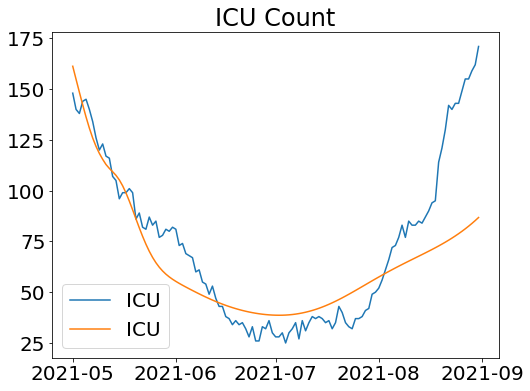

In [69]:
plt.figure(figsize=(8, 6))
preds=tf.reduce_mean(model.call(x_test), axis=-1)
plt.plot(df.loc[train_start:test_end].index.values, y_test['I_count'], label='ICU')
plt.plot(df.loc[train_start:test_end].index.values, preds[0][2], label='ICU')
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('ICU Count')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Gen Count')

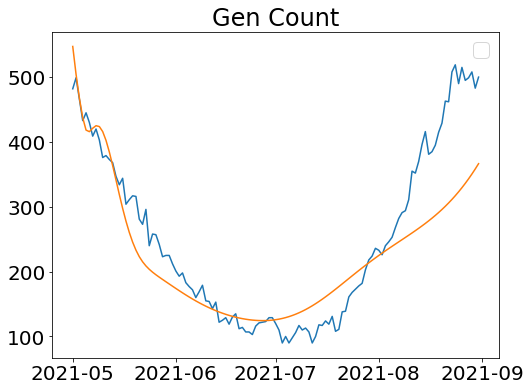

In [70]:
plt.figure(figsize=(8, 6))
plt.plot(df.loc[train_start:test_end].index.values, y_test['G_count'], )
plt.plot(df.loc[train_start:test_end].index.values, preds[0][0])
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Gen Count')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Gen Influx')

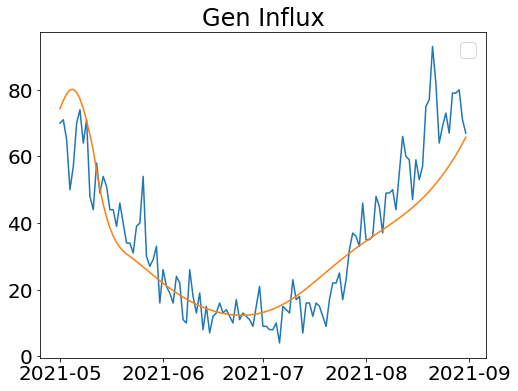

In [71]:
plt.figure(figsize=(8, 6))
plt.plot(df.loc[train_start:test_end].index.values, y_test['G_in'], )
plt.plot(df.loc[train_start:test_end].index.values, preds[0][1])
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Gen Influx')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Death Influx')

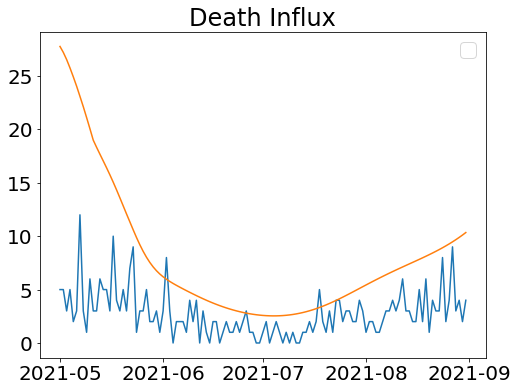

In [72]:
plt.figure(figsize=(8, 6))
plt.plot(df.loc[train_start:test_end].index.values, y_test['D_in'], )
plt.plot(df.loc[train_start:test_end].index.values, preds[0][3])
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Death Influx')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Forecasted Asymp In')

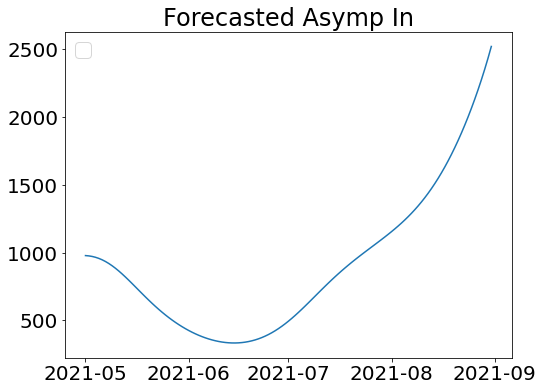

In [73]:
plt.figure(figsize=(8, 6))
plt.plot(df.loc[train_start:test_end].index.values,
         tf.reduce_mean(
        forecasted_fluxes[Comp.A.value][Vax.yes.value].stack() + forecasted_fluxes[Comp.A.value][Vax.no.value].stack(),
         axis=-1)
        )
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Forecasted Asymp In')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Forecasted Mild In')

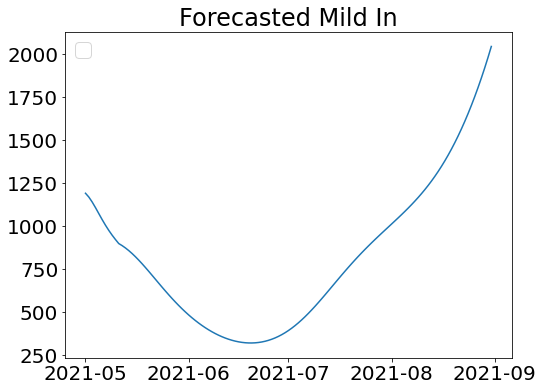

In [74]:
plt.figure(figsize=(8, 6))
plt.plot(df.loc[train_start:test_end].index.values,
         tf.reduce_mean(
        forecasted_fluxes[Comp.M.value][Vax.yes.value].stack() + forecasted_fluxes[Comp.M.value][Vax.no.value].stack(),
         axis=-1)
        )
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Forecasted Mild In')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Forecasted ICU In')

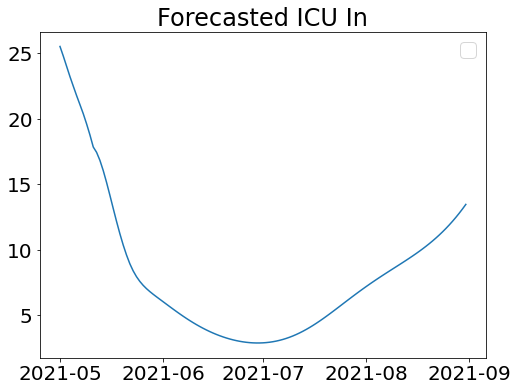

In [75]:
plt.figure(figsize=(8, 6))
plt.plot(df.loc[train_start:test_end].index.values,
         tf.reduce_mean(
        forecasted_fluxes[Comp.I.value][Vax.yes.value].stack() + forecasted_fluxes[Comp.I.value][Vax.no.value].stack(),
         axis=-1)
        )
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Forecasted ICU In')

In [ ]:
count_gen

In [ ]:
warmup_G

In [ ]:
warmup_mild[vax_status][0]/2/10

In [ ]:
warmup_asymp[vax_status][0]/2

In [ ]:
warmup_mild[vax_status][0]/2

In [ ]:
count_icu[vax_status]

In [ ]:
model.init_count_I_samples_constrained

In [ ]:
warmup_IR_params

In [ ]:
model.trainable_variables

In [ ]:
tfp.bijectors.Chain([tfp.bijectors.Softplus(), tfp.bijectors.Scale(100)]).forward(-2.0793715)

In [ ]:
tfp.bijectors.Chain([tfp.bijectors.Softplus(), tfp.bijectors.Scale(100)]).forward(200)

In [ ]:
tfp.bijectors.Chain([ tfp.bijectors.Scale(100), tfp.bijectors.Softplus()]).inverse(100)

In [ ]:
tfp.bijectors.Softplus().inverse(model.warmup_A_samples[0][0][0])

In [ ]:
tfp.bijectors.Chain([ tfp.bijectors.Scale(100), tfp.bijectors.Softplus()]).forward(model.warmup_A_samples[0][0][0])

In [ ]:
tfp.bijectors.Chain([tfp.bijectors.Softplus(), tfp.bijectors.Scale(100)]).forward(model.warmup_A_samples[0][0][0])

In [ ]:
tfp.bijectors.Chain([tfp.bijectors.Softplus(), tfp.bijectors.Scale(100)]).forward(
                        model.warmup_IR_samples[0][0])

In [ ]:
warmup_IR_params

In [ ]:
model.warmup_IR_samples[0][0].numpy().mean()

In [ ]:
len(model.losses)

In [ ]:
[[-tf.reduce_sum(tf.reduce_mean(
            model.prior_distros[Comp.IR.value][status.value]['warmup_IR'][day].log_prob(
                model.warmup_IR_samples[status.value][day]) + \
            tfp.bijectors.Chain([tfp.bijectors.Softplus(), tfp.bijectors.Scale(100)]).forward_log_det_jacobian(
                model.warmup_IR_samples[status.value][day])
            - model.warmup_IR_probs[status.value][day], axis=-1)) for day in range(model.transition_window)] for status in
                                             model.vax_statuses]

In [ ]:
model.prior_distros[Comp.IR.value][0]['warmup_IR'][0].log_prob(
                model.warmup_IR_samples[0][0]) + \
tfp.bijectors.Chain([tfp.bijectors.Softplus(), tfp.bijectors.Scale(100)]).forward_log_det_jacobian(
                model.warmup_IR_samples[0][0])

In [ ]:
warmup_IR_params

In [ ]:
tfp.bijectors.Chain([tfp.bijectors.Softplus(), tfp.bijectors.Scale(100)]).forward(
              10.0/100/2)

In [ ]:
warmup_mild[vax_status][0]/2

In [ ]:
warmup_mild[vax_status][0]/2/10/10/10

In [ ]:
model.prior_distros[Comp.IR.value][0]['warmup_IR'][0].log_prob(-0.01)

In [ ]:
count_gen

In [ ]:
tfp.math.softplus_inverse(10.0/100/2)

In [ ]:
tfp.bijectors.Softplus().inverse(10.0/100/2)

In [ ]:
tfp.bijectors.Chain([tfp.bijectors.Softplus(), tfp.bijectors.Scale(100)]).forward(tfp.math.softplus_inverse(10.0/2)/100)

In [ ]:
model.init_count_I_samples_constrained[0].numpy().mean()

In [ ]:
preds[0][2]

In [ ]:
model.warmup_IR_samples_constrained[vax_status]

In [ ]:
model.losses

In [ ]:
model.prior_distros[Comp.I.value][0]['warmup_I'][3].parameters['distribution'].mean()

In [ ]:
model.warmup_I_samples_constrained[0][-1]

In [ ]:
model.warmup_I_samples_constrained[vax_status][2] - \
                                                   model.warmup_IR_samples_constrained[vax_status][2]

In [ ]:
model.losses

In [ ]:
pre_training_preds[0][0].numpy().mean(axis=1)

In [ ]:
model.rho_D_samples

In [ ]:
model.warmup_I_samples_constrained[0][-1]

In [ ]:
count_gen

In [ ]:
init_count_I

In [ ]:
warmup_I_params

In [31]:
df

,icu_count,general_ward_count,deaths_covid,asymp,extreme,mild,Rt,general_ward_in,vax_pct
date,,,,,,,,,
2019-12-25,NaN,NaN,NaN,0.000006,6.555663e-11,5.714537e-08,0.992215,NaN,NaN
2019-12-26,NaN,NaN,NaN,0.000006,5.584121e-10,3.892314e-07,1.055331,NaN,NaN
2019-12-27,NaN,NaN,NaN,0.000006,2.045071e-09,1.009780e-06,1.110538,NaN,NaN
2019-12-28,NaN,NaN,NaN,0.000007,4.996819e-09,1.784756e-06,1.158677,NaN,NaN
2019-12-29,NaN,NaN,NaN,0.000007,9.617803e-09,2.581918e-06,1.201151,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-08-31,171.0,500.0,4.0,5744.449475,4.605118e+01,3.266123e+03,1.190514,67.0,0.6597
2021-09-01,161.0,490.0,12.0,5959.757047,4.741058e+01,3.375344e+03,1.197465,85.0,0.6604
2021-09-02,168.0,517.0,10.0,NaN,NaN,NaN,NaN,72.0,0.6613
